In [78]:
import librosa
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
DATASET = './DataSets/Emotions'

In [5]:
def remove_silence(signal, threshold=0.005):
    """
    Remove silence at the beginning and at the end of the signal
    """
    i = j = 0
    for i in range(len(signal)):
        if np.abs(signal[i]) > threshold:
            break
    for j in range(len(signal)-1, 0, -1):
        if np.abs(signal[j]) > threshold:
            break
    return signal[i:j]

In [107]:
paths=[]
names=[]

for dirname, _, filenames in os.walk(DATASET):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        name = dirname[::].split('/')[2].split('\\')[1]
        names.append(name.lower())

In [108]:
data = pd.DataFrame({'speech':paths, 'name':names})
data.sample(5)

,speech,name
5573,./DataSets/Emotions\Fearful\1084_IWW_FEA_XX.wav,fearful
11371,./DataSets/Emotions\Sad\1069_IWL_SAD_XX.wav,sad
6651,./DataSets/Emotions\Happy\1015_IOM_HAP_XX.wav,happy
403,./DataSets/Emotions\Angry\1002_WSI_ANG_XX.wav,angry
11916,./DataSets/Emotions\Sad\OAF_rose_sad.wav,sad


In [112]:
# Labelencoder para convertir las clases a etiquetas númericas
label_encoder = LabelEncoder()

# Encode labels in column 'label'.
data['label'] = label_encoder.fit_transform(data['name'])

In [115]:
data[['label', 'name']].value_counts()

label  name     
0      angry        2167
3      happy        2167
5      sad          2167
2      fearful      2047
1      disgusted    1863
4      neutral      1795
6      suprised      592
dtype: int64

In [30]:
# Coeficientes Septrales - Transformación del audio en una serie de parametros que representan de forma compacta el sonido
def MFCC(filename):
    y, sr = librosa.load(filename, res_type='kaiser_fast')
    y = remove_silence(y)
    if len(y) == 0:
        return np.zeros(130)
    values = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=65).T
    mean = np.mean(values, axis=0)
    std = np.std(values, axis=0)
    mfccs = np.concatenate((mean, std), axis=0)
    return mfccs

In [32]:
data['mfcc'] = data['speech'].apply(lambda x: MFCC(x))

In [65]:
np.save('Datasets/naive_mfcc.npy', data['mfcc'].to_list())
np.save('Datasets/naive_label.npy', data['label'])

## Naive Bayes

In [66]:
X = np.load('./DataSets/naive_mfcc.npy', allow_pickle=True)
y = np.load('./DataSets/naive_label.npy', allow_pickle=True)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [94]:
#Estandarizar
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [95]:
# hiperparametros para evaluar el modelo
grid = {
    'alpha': np.linspace(0, 1, 101),
    'fit_prior': [True, False],
}

f1_custom = make_scorer(f1_score, average='micro')

# modelo para encontrar los mejores hiperparametros
grid_search = GridSearchCV(MultinomialNB(), grid, n_jobs=-1, scoring=f1_custom, cv=5)
grid_search.fit(X_train, y_train)
logistic_params = grid_search.best_params_

# se muestran los mejores hiperparametros y score obtenidos
print("best score:      ", grid_search.best_score_)
print("best params:     ", grid_search.best_params_)

best score:       0.3254042131036812
best params:      {'alpha': 0.0, 'fit_prior': True}


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [96]:
grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

f1_custom = make_scorer(f1_score, average='micro')

# modelo para encontrar los mejores hiperparametros
grid_search = GridSearchCV(GaussianNB(), grid, n_jobs=-1, scoring=f1_custom, cv=5)
grid_search.fit(X_train, y_train)
logistic_params = grid_search.best_params_

# se muestran los mejores hiperparametros y score obtenidos
print("best score:      ", grid_search.best_score_)
print("best params:     ", grid_search.best_params_)

best score:       0.3059564894220099
best params:      {'var_smoothing': 6.579332246575683e-05}


In [97]:
grid = {
    'alpha': np.linspace(0, 1, 11),
    'fit_prior': [True, False],
    'binarize': np.linspace(0, 1, 11)
}

f1_custom = make_scorer(f1_score, average='micro')

# modelo para encontrar los mejores hiperparametros
grid_search = GridSearchCV(BernoulliNB(), grid, n_jobs=-1, scoring=f1_custom, cv=5)
grid_search.fit(X_train, y_train)
logistic_params = grid_search.best_params_

# se muestran los mejores hiperparametros y score obtenidos
print("best score:      ", grid_search.best_score_)
print("best params:     ", grid_search.best_params_)

best score:       0.36013227764510064
best params:      {'alpha': 0.0, 'binarize': 0.7000000000000001, 'fit_prior': True}


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [98]:
#Predecir sobre el train y sobre el test
y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

In [99]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy en el conjunto de train: {accuracy_train}')
print(f'Accuracy en el conjunto de test: {accuracy_test}')

Accuracy en el conjunto de train: 0.36837992707067196
Accuracy en el conjunto de test: 0.3546875


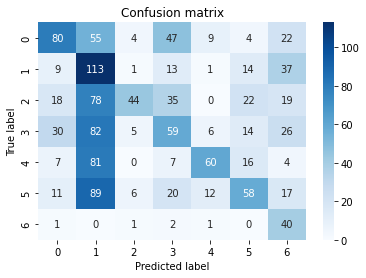

In [103]:
cm2_test = confusion_matrix(y_test, y_pred_test)

#Graficar la matriz de confusión.
sns.heatmap(cm2_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [104]:
report_test2 = classification_report(y_test ,y_pred_test.round())  
print(report_test2)

              precision    recall  f1-score   support

           0       0.51      0.36      0.42       221
           1       0.23      0.60      0.33       188
           2       0.72      0.20      0.32       216
           3       0.32      0.27      0.29       222
           4       0.67      0.34      0.45       175
           5       0.45      0.27      0.34       213
           6       0.24      0.89      0.38        45

    accuracy                           0.35      1280
   macro avg       0.45      0.42      0.36      1280
weighted avg       0.48      0.35      0.36      1280



In [109]:
pickle.dump(grid_search, open('Models/NaiveBayes.model','wb'))